<a href="https://colab.research.google.com/github/waleedGeorgy/deep-learning/blob/main/Deep_Learning_Models_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting set up

In [43]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [45]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [46]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

# Training the model we will deploy

The model we'll deploy will be trained on the "pizza steak sushi 20%" dataset.

Using this dataset, we will train two models that previously showed great results for our use-case. These models are: **EfficientNetB2** and the **ViT-B/16** feature extractors.

Our goal is get a model that is accurate (e.g. +95% accuracy) and almost instantaneous (when making predictions).

## EfficientNetB2 feature extractor

In [47]:
# A class to creat an EffnetB2 model and transforms
def create_effnetb2(num_class: int,
                    seed: int = 42):
  """
  A class to create an EfficientNetB2 feature extractor with DEFAULT weights

  Args:
    num_class (int): number of classes in the classifier head (int).
    seed (int): random seed values (int, default = 42)

  Returns:
    model (torch.nn.Module): an instance of the EfficientNetB2 feature extractor with DEFAULT weights.
    transforms (torchvision.transforms): an instant of the EfficientNetB2 transforms
  """
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for param in model.features.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3, inplace = True),
      nn.Linear(in_features = 1408, out_features = num_class, bias = True)
  )

  return model, transforms

In [48]:
effnetb2, effnetb2_transforms = create_effnetb2(num_class=3,
                                                seed = 42)

In [49]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [50]:
summary(model = effnetb2,
        input_size = (32,3,288,288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 

In [51]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

class_names

['pizza', 'steak', 'sushi']

In [52]:
# Setting up the training
from going_modular.going_modular import engine
from timeit import default_timer as timer

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_start = timer()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)
effnetb2_end = timer()
effnetb2_train_time = effnetb2_end - effnetb2_start
print(f'[INFO] Total training time: {effnetb2_train_time:.2f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625
[INFO] Total training time: 56.73 seconds


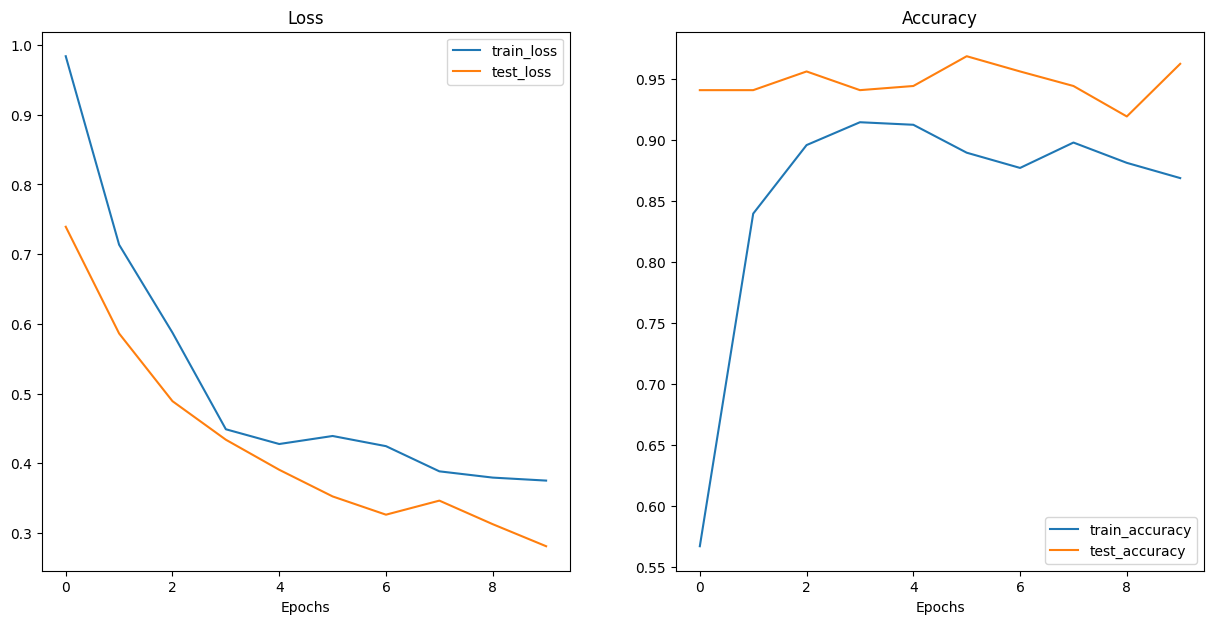

In [53]:
# Plotting the loss and accuracy curves
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [54]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2.pth")

[INFO] Saving model to: models/effnetb2.pth


Another "parameter" we need to take into account is model's size in megabytes.

The EfficientNetB2 feature extractor is about 30 MBs, which is relatively small, especially in the context of our application.

In [55]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [56]:
# Saving model's results to a dictionary
from pathlib import Path

effnetb2_numbers = {'test_loss' : effnetb2_results['test_loss'][-1],
                    'test_accuracy' : effnetb2_results['test_acc'][-1],
                    'total_params' : effnetb2_total_params,
                    'training_time' : effnetb2_train_time,
                    'model_size' : Path("/content/models/effnetb2.pth").stat().st_size // (1024*1024)}

In [57]:
effnetb2_numbers

{'test_loss': 0.28108686208724976,
 'test_accuracy': 0.9625,
 'total_params': 7705221,
 'training_time': 56.727879099000006,
 'model_size': 29}

## ViT-B/16 feature extractor

In [58]:
# Creating the ViT-B/16 model and transforms
def create_vitb16(num_class:int = 3, seed:int = 42):
  """
  A class to create a ViT-B/16 feature extractor with DEFAULT weights

  Args:
    num_class (int): number of classes in the classifier head (int).
    seed (int): random seed values (int, default = 42)

  Returns:
    model (torch.nn.Module): an instance of the ViT-B/16 feature extractor with DEFAULT weights.
    transforms (torchvision.transforms): an instant of the ViT-B/16 transforms
  """
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_class))

  return model, transforms

In [59]:
vitb16, vitb16_transforms = create_vitb16()

In [60]:
summary(model = vitb16,
        input_size = (1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [61]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vitb16, test_dataloader_vitb16, class_names_vitb16 = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=vitb16_transforms,
                                                                                                 batch_size=32)

class_names_vitb16

['pizza', 'steak', 'sushi']

In [62]:
# Setting up the training
from going_modular.going_modular import engine
from timeit import default_timer as timer

optimizer = torch.optim.Adam(params=vitb16.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

vitb16_start = timer()

vitb16_results = engine.train(model=vitb16,
                              train_dataloader=train_dataloader_vitb16,
                              test_dataloader=test_dataloader_vitb16,
                              epochs=10,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              device=device)

vitb16_end = timer()

vitb16_train_time = vitb16_end - vitb16_start

print(f'[INFO] Total training time: {vitb16_train_time:.2f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847
[INFO] Total training time: 89.31 seconds


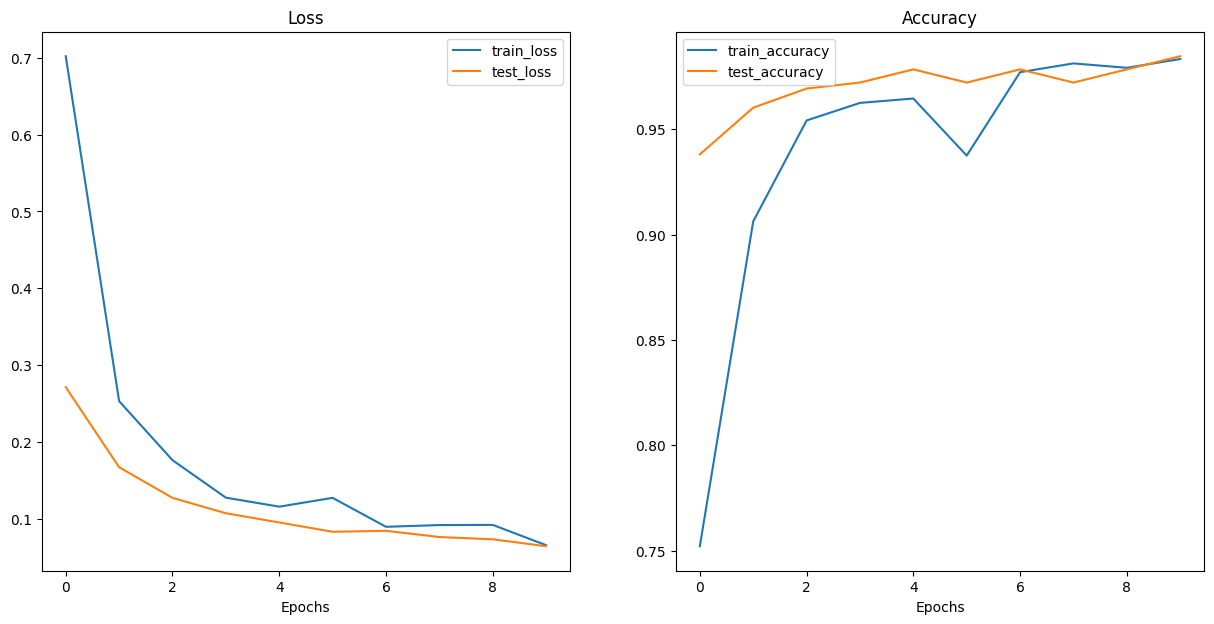

In [63]:
# Plotting the loss and accuracy curves
from helper_functions import plot_loss_curves

plot_loss_curves(vitb16_results)

In [64]:
from going_modular.going_modular import utils

utils.save_model(model=vitb16,
                 target_dir="models",
                 model_name="vitb16.pth")

[INFO] Saving model to: models/vitb16.pth


In [65]:
# Count number of parameters in EffNetB2
vitb16_total_params = sum(torch.numel(param) for param in vitb16.parameters())
vitb16_total_params

85800963

In [66]:
# Saving model's results to a dictionary
from pathlib import Path

vitb16_numbers = {'test_loss' : vitb16_results['test_loss'][-1],
                    'test_accuracy' : vitb16_results['test_acc'][-1],
                    'total_params' : vitb16_total_params,
                    'training_time' : vitb16_train_time,
                    'model_size' : Path("/content/models/vitb16.pth").stat().st_size // (1024*1024)}

vitb16_numbers

{'test_loss': 0.06443451717495918,
 'test_accuracy': 0.984659090909091,
 'total_params': 85800963,
 'training_time': 89.31441854499997,
 'model_size': 327}

In [67]:
effnetb2_numbers

{'test_loss': 0.28108686208724976,
 'test_accuracy': 0.9625,
 'total_params': 7705221,
 'training_time': 56.727879099000006,
 'model_size': 29}

As we outlined previously, we want our models to have high accuracy (+95% accuracy) and to make almost instantaneous predictions (~ 0.03 seconds).

The first criteria has been met with both of the models. Next, we will evaluate how fast said models can make predictions

In [68]:
test_img_list = list(Path(test_dir).glob('*/*.jpg'))
img = torchvision.io.read_image(str(test_img_list[0]))
img.shape

torch.Size([3, 384, 512])

In [69]:
# Calculating mean prediction time using EfficientNetB2
import PIL

set_seeds()

effnetb2_total_time = 0

for img_path in test_img_list:

  start_time = timer()

  img = torchvision.io.read_image(str(img_path))
  transformed_img = effnetb2_transforms(img).unsqueeze(0).to(device)

  effnetb2.eval()
  with torch.inference_mode():

    y_logits = effnetb2(transformed_img)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  end_time = timer()

  pred_time = end_time - start_time
  effnetb2_total_time += pred_time

mean_pred_time_effnetb2 = round(effnetb2_total_time / len(test_img_list), 4)
print(f'Total prediction time on the test data using EfficientNetB2: {effnetb2_total_time:.4f} seconds')
print(f'Mean prediction time using EfficientNetB2 feature extractor: {mean_pred_time_effnetb2} seconds')

Total prediction time on the test data using EfficientNetB2: 3.5352 seconds
Mean prediction time using EfficientNetB2 feature extractor: 0.0236 seconds


In [70]:
# Calculating mean prediction time using ViT-B/16

set_seeds()

vitb16_total_time = 0

for img_path in test_img_list:

  start_time = timer()

  img = torchvision.io.read_image(str(img_path))
  transformed_img = vitb16_transforms(img).unsqueeze(0).to(device)

  vitb16.eval()
  with torch.inference_mode():

    y_logits = vitb16(transformed_img)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  end_time = timer()
  pred_time = end_time - start_time
  vitb16_total_time += pred_time

mean_pred_time_vitb16 = round(vitb16_total_time / len(test_img_list), 4)
print(f'Total prediction time on the test data using ViT-B/16: {vitb16_total_time:.4f} seconds')
print(f'Mean prediction time using ViT-B/16 feature extractor: {mean_pred_time_vitb16:} seconds')

Total prediction time on the test data using ViT-B/16: 2.2726 seconds
Mean prediction time using ViT-B/16 feature extractor: 0.0152 seconds


In [71]:
# Apeending mean pred times to existing models performances dictionaries
effnetb2_numbers['mean_pred_time'] = mean_pred_time_effnetb2
vitb16_numbers['mean_pred_time'] = mean_pred_time_vitb16

# Adding models' names for reference
effnetb2_numbers['model'] = 'EfficientNetB2'
vitb16_numbers['model'] = 'ViT-B/16'

In [72]:
# Turning info into a dataframe for readability
import pandas as pd
models_df = pd.DataFrame([effnetb2_numbers])
models_df.append([vitb16_numbers])

<ipython-input-72-f93b4a850a3e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_df.append([vitb16_numbers])


,test_loss,test_accuracy,total_params,training_time,model_size,mean_pred_time,model
0,0.281087,0.962500,7705221,56.727879,29,0.0236,EfficientNetB2
0,0.064435,0.984659,85800963,89.314419,327,0.0152,ViT-B/16


As we can see, both of the models achieved the desired mean prediction time (less than 0.03 seconds).

Since both models also achieved the desired accuracy, we will pick a model that is more suited to our use-case based off other criteria like the size of the model, its training time, etc.